In [1]:
#Cambiando Q=0.1 azul
#Con radiofrecuencia de 4.5 * np.pi * 10**6 q=0.1 (#13 minutos)
#C6= 5.607E-56
#q= 0.1
#Le alta estructura a la trampa para el ion en relación al
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, cpu_count
import time
import logging

#Ion: Yb+ , atom: Li

#constants
m_ion = 2.8733965E-25  #(YB+) 2,8733965 × 10^-25 kg (SR+ 2.83E-25)
m_atom = 1.1525E-26 # (LITIO) 1,1525801 × 10^-26 kg (RB 1.44E-25 )
C4=5.607E-56 #C4=5.607E-57   Paper Prospects #C4=1.1E-56 RbSr+
C6=5E-19 * C4   #C6=5.0E-19     Paper Prospects (LIYB+) C6 = 2.803 × 10−75 Jm6 C4 = 2.803 × 10−57
frf = 2.5 * 10**6
Omega= 2.0 * np.pi * frf #MHz #Depende tambien mucho de esta fase
a = -2.982E-4  #-3E-7, da un buen comportamiento
q = 0.1   #Entre 0.1 y otro
T_ion =  0 # da un buen comportamiento  0.5 milikelvin   Paper Ziv Meir (de Jesus)
T_atom = 0.1E-6  #0.1E-6, da un buen comportamiento   #6 microkelvin (mucho más frio átomo que ion) Paper Ziv Meir
r0 = 0.1E-6
ti= 0.0
tf= 200E-6          #0.001, da un buen comportamiento pal ion #de matlab 200e-6;
dt= 10000
ptol = 1e-10
kB = 1.38064E-23
num_cpus = 24
num_solution = 10
num_collisions = 500

logging.basicConfig(level=logging.INFO)

def system(t, y, a, q, Omega, C4, C6, m_ion, m_a):

    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y

    # Definición de las ecuaciones diferenciales
    dydt = np.zeros_like(y)

    #Velocidades del ion
    dydt[0] = ionvx
    dydt[1] = ionvy
    dydt[2] = ionvz

    #velocidades del átomo
    dydt[6] = atomvx
    dydt[7] = atomvy
    dydt[8] = atomvz

    #Potencial para el ion
    dydt[3] = -(a+2*q*np.cos(Omega*t))*ionx*(Omega**2 / 4)
    dydt[4] = -(a+2*q*np.cos(Omega*t))*iony*(Omega**2 / 4)
    dydt[5] = -(2*a+2*-q*np.cos(Omega*t))*ionz*(Omega**2 / 4)

    #Interacción con el potencial atom
    r = np.sqrt((atomx - ionx)**2 + (atomy - iony)**2 + (atomz - ionz)**2)

    dydt[3] += -(2*C4/r**5 -6 *C6 / r**7) * (ionx - atomx) / (m_ion * r)
    dydt[4] += -(2*C4/r**5 -6 *C6 / r**7) * (iony - atomy) / (m_ion * r)
    dydt[5] += -(2*C4/r**5 -6 *C6 / r**7) * (ionz - atomz) / (m_ion * r)

    dydt[9] += -(2*C4/r**5 -6 *C6 / r**7) * (atomx - ionx) / (m_atom * r)
    dydt[10] += -(2*C4/r**5 -6 *C6 / r**7) * (atomy - iony) / (m_atom * r)
    dydt[11] += -(2*C4/r**5 -6 *C6 / r**7) * (atomz - ionz) / (m_atom * r)

    return dydt

#Funciones
def position_on_sphere(radius):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)
    # Convertir a coordenadas cartesianas
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

def velocidad_atom(temperature, mass, x, y, z):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)

    kb = 1.380649e-23  # Constante de Boltzmann en m^2 kg s^-2 K^-1

    # Spherical velocities
    v_theta = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_phi = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_r = -abs(np.random.weibull(2) * np.sqrt(2 * kb * temperature / mass))

    # Componentes de velocidad en coordenadas cartesianas
    v_x = v_r * np.sin(theta) * np.cos(phi) + v_theta * np.cos(theta) * np.cos(phi) - v_phi * np.sin(phi)
    v_y = v_r * np.sin(theta) * np.sin(phi) + v_theta * np.cos(theta) * np.sin(phi) + v_phi * np.cos(phi)
    v_z = v_r * np.cos(theta) - v_theta * np.sin(theta)

    return v_x, v_y, v_z

def velocidad_ion(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

#Colision se detiene si átomo sale de segunda esfera de radio 2E-7
def event_condition(t, y, a, q, Omega, C4, C6, m_ion, m_a):
    # Definir condición de evento
    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y
    s = np.sqrt((atomx)**2 + (atomy)**2 + (atomz)**2)
    return s - 2.0E-6  #0.1E-6

# Indicar que el evento se debe buscar a través del cruce con cero
event_condition.terminal = True
event_condition.direction = 1

# Definición del vector de tiempo
t_span = (ti, tf)

# Resolución del sistema de ecuaciones diferenciales
def run_simulation(i):

    ionx_0=0.0
    iony_0=0.0
    ionz_0=0.0
    ionvx_0=velocidad_ion(T_ion, m_ion)
    ionvy_0=velocidad_ion(T_ion, m_ion)
    ionvz_0=velocidad_ion(T_ion, m_ion)
    atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
    atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
    y0 = [ionx_0, iony_0, ionz_0, ionvx_0, ionvy_0, ionvz_0, atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    results = []

    for collision in range (num_collisions):
          #inicialization variables
        solution = solve_ivp(system, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], dt), method='RK45', args=(a, q, Omega, C4, C6, m_ion, m_atom), rtol=ptol)

        # Extracción de las soluciones temporales
        t_sol = solution.t
        ionx_sol = solution.y[0]
        iony_sol = solution.y[1]
        ionz_sol = solution.y[2]
        ionvx_sol = solution.y[3]
        ionvy_sol = solution.y[4]
        ionvz_sol = solution.y[5]
        atomx_sol = solution.y[6]
        atomy_sol = solution.y[7]
        atomz_sol = solution.y[8]
        atomvx_sol = solution.y[9]
        atomvy_sol = solution.y[10]
        atomvz_sol = solution.y[11]

        results.append([t_sol, ionx_sol, iony_sol, ionz_sol, ionvx_sol, ionvy_sol, ionvz_sol, atomx_sol, atomy_sol, atomz_sol, atomvx_sol, atomvy_sol, atomvz_sol])

        #Se actulizan las condiciones para el ion y el atomo
        atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
        atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
        y0 = [ionx_sol[-1], iony_sol[-1], ionz_sol[-1], ionvx_sol[-1], ionvy_sol[-1], ionvz_sol[-1], atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    return results


if __name__ == '__main__':

    logging.info("Inicio de la ejecución")
    start_time = time.time()
    num_cpus = 24

    with Pool(processes=num_cpus) as pool:
        all_results = pool.map(run_simulation, range(num_solution))
    #print(all_results)

    end_time = time.time()
    execution_time = (end_time - start_time)/60
    logging.info("Ejecución completada")
    print(f"Tiempo total de ejecución con 12 nucleos: {execution_time:.2f}minutos")
    Ekin_total = []
    for i, results in enumerate (all_results):   #cada colision en numero de trayectorias
        Ekin_colision = []
        for j, result in enumerate (results):     #parametros de cada colision
            t_sol=result[0]
            ionx_sol=result[1]
            iony_sol=result[2]
            ionz_sol=result[3]
            ionvx_sol=result[4]
            ionvy_sol=result[5]
            ionvz_sol=result[6]
            atomx_sol=result[7]
            atomy_sol=result[8]
            atomz_sol=result[9]
            atomvx_sol=result[10]
            atomvy_sol=result[11]
            atomvz_sol=result[12]

            E_kin = 0.5 * m_ion * (ionvx_sol**2 + ionvy_sol**2 + ionvz_sol**2)
            Tkin = np.mean(0.5 * m_ion * (ionvx_sol[1:]**2 + ionvy_sol[1:]**2 + ionvz_sol[1:]) * (t_sol[1:] - t_sol[:-1]) / (t_sol[-1] - t_sol[0]) * (len(t_sol) - 1)) * 1 / (3/2 * kB) * 1e6
            Ekin_colision.append(Tkin)
            t_mean = np.mean(t_sol)
            t_max = max(t_sol)  # Maximum value of the time array
            E_max = max(E_kin)  # Maximum value of the kinetic energy array
        Ekin_total.append(Ekin_colision)

    Ekin_total_promedio = np.mean(Ekin_total, axis=0)
    #plt.text(0.95, 0.95, '(a)', transform=plt.gca().transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right')
    #print("Ekin_total_promedio", Ekin_total_promedio)

# Definir el rango máximo
#umbral_maximo = 20 # Ajusta este valor según tu necesidad

# Filtrar los datos por debajo del umbral máximo
#indices_validos = np.where(Ekin_total_promedio < umbral_maximo)
#Ekin_filtrado = np.array(Ekin_total_promedio)[indices_validos]
#num_collisiones_filtrado = np.arange(len(Ekin_total_promedio))[indices_validos]

# Graficar los datos filtrados
#plt.plot(num_collisiones_filtrado, Ekin_filtrado, label='Energía Cinética Promedio Filtrada')
#plt.title('Energía Cinética Promedio Filtrada por Número de Colisiones')
#plt.xlabel('Número de Colisiones')
#plt.ylabel('Energía Cinética Promedio (μK)')
#plt.grid()
#plt.legend()
#plt.show()

INFO:root:Inicio de la ejecución
INFO:root:Ejecución completada


Tiempo total de ejecución con 12 nucleos: 138.05minutos


[  0.75653903   0.67407102   0.68021875   1.07785546   1.05757882
   0.34718003  65.3668395    1.23060933   4.6644414    2.9865498
   1.71684039   2.58814032   2.81087278   2.65004001   3.68592576
   2.48961285   4.02524922   3.68852847   3.96256386   4.36204018
   4.20185129   5.79804341   4.36867267   6.57114291   5.0152128
   3.81224603   7.56305268  15.56784826   6.34451439   7.5942603
   4.7788039    3.2024221    6.27801581   2.85487861   4.89831626
   6.98356459   3.63989918  18.65357092   5.04907244  14.19215547
   7.93031666   4.67406634   5.19813484   4.8535033    3.58132984
   5.38327105   5.16307353   6.00838924   6.25251968   2.82323641
   4.89573424   3.74108453   4.50371797   9.51985754   5.41232202
   5.46155944   6.57170489   5.12384695   5.68503998   5.03356137
   8.81328755   6.16557326   6.26452087   6.50008217   5.9697728
 162.49105285   5.49342806   4.99740795   6.18866625   5.09682655
   4.94263713   8.06292526   5.32159145   6.48902164   5.33072996
   4.07762119 

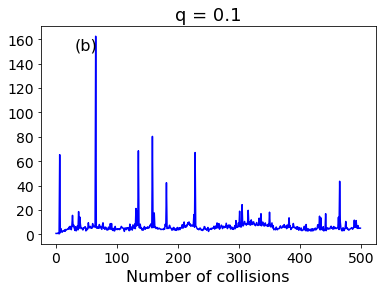

In [2]:
print(Ekin_total_promedio)
plt.plot(Ekin_total_promedio, label='Average Kinetic Energy', color='blue')
plt.text(0.1, 0.95, '(b)', transform=plt.gca().transAxes, fontsize=16, verticalalignment='top', horizontalalignment='left')
plt.title('q = 0.1', fontsize=18)  # Title with reference label and larger font size
plt.xlabel('Number of collisions', fontsize=16)
plt.ylabel('', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [3]:
import pandas as pd

# Después de calcular Ekin_total
df = pd.DataFrame(Ekin_total_promedio)
df.to_csv('Q_0.1.csv', index=False)

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
